# Hierarchical policies

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for hierarchical policies.

## Import statements

In [1]:
import sys
sys.path.append("../../..")
from job_table import JobTable
import utils
from plotting_utils import plot_runtimes, plot_effective_throughput_ratios
from policies.max_min_fairness_water_filling \
    import MaxMinFairnessWaterFillingPolicyWithPerf

import copy
from contextlib import redirect_stderr, redirect_stdout
import numpy as np
from os import devnull
import random
import time

np.set_printoptions(precision=3, suppress=True)

## Harness that runs a policy with the passed-in number of sub-clusters

In [2]:
def create_problem_instance(priority_reweighting_policy, num_jobs,
                            cluster_size,
                            random_throughputs=True):
    oracle_throughputs = utils.read_all_throughputs_json_v2(
        "../../../simulation_throughputs.json")
    random.seed(0)
    num_entities = 3
    priority_reweighting_policies = {}
    entity_weights = {}
    unflattened_priority_weights = {}
    entity_to_job_mapping = {}
    for i in range(num_entities):
        entity_id = 'entity%d' % i
        priority_reweighting_policies[entity_id] = priority_reweighting_policy
        entity_to_job_mapping[entity_id] = []
        entity_weights[entity_id] = (i + 1)

    worker_types = ['k80', 'p100', 'v100']
    cluster_spec = {worker_type: cluster_size for worker_type in worker_types}
    unflattened_throughputs = {}
    scale_factors = {}
    num_workers_requested = 0
    for i in range(num_jobs):
        if random_throughputs:
            throughputs = [random.random() for j in range(len(worker_types))]
            throughputs.sort()
            unflattened_throughputs[i] = {
                worker_types[j]: throughputs[j] for j in range(len(worker_types))}
        else:
            job_type = random.choice(JobTable).model
            unflattened_throughputs[i] = {
                worker_type: oracle_throughputs[worker_type][(job_type, 1)]['null']
                for worker_type in worker_types}
        scale_factors[i] = 1
        num_workers_requested += scale_factors[i]
        entity_id = 'entity%d' % random.randint(0, 2)
        priority_weight = (i % 2) + 1
        if priority_reweighting_policies[entity_id] == 'fifo':
            priority_weight = 1.0
        unflattened_priority_weights[i] = priority_weight
        entity_to_job_mapping[entity_id].append(i)
        
    return (unflattened_throughputs, scale_factors, unflattened_priority_weights,
            cluster_spec, entity_weights, entity_to_job_mapping), priority_reweighting_policies

In [3]:
def harness(policy, problem_instance, num_sub_clusters,
            random_cluster_assignment):
    all_effective_throughputs = {}
    orig_policy = copy.deepcopy(policy)

    start_time = time.time()
    (throughputs, scale_factors, priority_weights,
     cluster_spec, entity_weights, entity_to_job_mapping) = problem_instance

    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_priority_weights = []
    sub_cluster_entity_to_job_mappings = []
    job_to_sub_cluster_assignment = {}
    job_ids = []
    for job_id in throughputs:
        job_ids.append(job_id)
    for i, job_id in enumerate(job_ids):
        if random_cluster_assignment:
            job_to_sub_cluster_assignment[job_id] = random.randint(0, num_sub_clusters-1)
        else:
            job_to_sub_cluster_assignment[job_id] = job_id % num_sub_clusters
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_priority_weights.append({})
        sub_cluster_entity_to_job_mappings.append({})
        for job_id in throughputs:
            if job_to_sub_cluster_assignment[job_id] == i:
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                sub_cluster_priority_weights[-1][job_id] = priority_weights[job_id]
        for entity_id in entity_to_job_mapping:
            sub_cluster_entity_to_job_mappings[-1][entity_id] = []
            for job_id in entity_to_job_mapping[entity_id]:
                if job_to_sub_cluster_assignment[job_id] == i:
                    sub_cluster_entity_to_job_mappings[-1][entity_id].append(job_id)
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}

    for i in range(num_sub_clusters):
        # TODO: Make it possible to reuse same policy object for multiple runs.
        policy = copy.deepcopy(orig_policy)
        with open(devnull, 'w') as fnull:
            with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
                effective_throughputs, job_ids = policy.get_allocation(
                    sub_cluster_throughputs[i],
                    sub_cluster_scale_factors[i],
                    sub_cluster_priority_weights[i],
                    sub_cluster_cluster_spec, entity_weights,
                    sub_cluster_entity_to_job_mappings[i],
                    return_effective_throughputs=True,
                    verbose=False)
                for i in range(len(job_ids)):
                    all_effective_throughputs[job_ids[i]] = effective_throughputs[i]
        (_, _, priority_weights, _, entity_weights, entity_to_job_mapping) = problem_instance

    return all_effective_throughputs, time.time() - start_time

## Runtimes

In [4]:
def get_runtimes(all_num_jobs,
                 priority_reweighting_policy,
                 random_throughputs,
                 random_cluster_assignment):
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }
    for num_jobs in all_num_jobs:
        cluster_size = num_jobs // 4
        problem_instance, priority_reweighting_policies = \
            create_problem_instance(priority_reweighting_policy,
                                    num_jobs,
                                    cluster_size,
                                    random_throughputs=random_throughputs)
        _, vanilla_runtime = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=1,
            random_cluster_assignment=random_cluster_assignment)
        _, four_sub_clusters_runtime = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=4,
            random_cluster_assignment=random_cluster_assignment)
        _, sixteen_sub_clusters_runtime = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=16,
            random_cluster_assignment=random_cluster_assignment)
        for (policy_label, runtime) in zip(['Vanilla', '4 sub-clusters', '16 sub-clusters'],
                                           [vanilla_runtime, four_sub_clusters_runtime,
                                            sixteen_sub_clusters_runtime]):
            data['policy'].append(policy_label)
            data['num_jobs'].append(num_jobs)
            data['runtimes'].append(runtime)
    
    return data

In [5]:
def get_effective_throughput_ratios(num_jobs,
                                    priority_reweighting_policy,
                                    random_throughputs,
                                    random_cluster_assignment):
    cluster_size = num_jobs // 4
    problem_instance, priority_reweighting_policies = \
        create_problem_instance(priority_reweighting_policy,
                                num_jobs,
                                cluster_size,
                                random_throughputs=random_throughputs)
    vanilla_effective_throughputs, _ = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=1,
            random_cluster_assignment=random_cluster_assignment)
    four_sub_clusters_effective_throughputs, _ = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=4,
            random_cluster_assignment=random_cluster_assignment)
    sixteen_sub_clusters_effective_throughputs, _ = harness(
            MaxMinFairnessWaterFillingPolicyWithPerf(
                priority_reweighting_policies=priority_reweighting_policies), problem_instance,
            num_sub_clusters=16,
            random_cluster_assignment=random_cluster_assignment)
    return [vanilla_effective_throughputs, four_sub_clusters_effective_throughputs,
            sixteen_sub_clusters_effective_throughputs]

## Effective throughput ratios

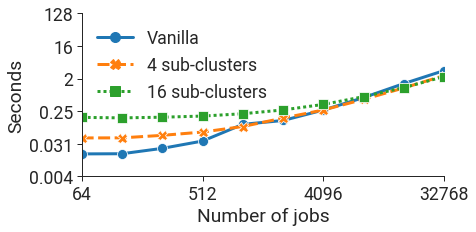

In [6]:
all_num_jobs = [64, 128, 256, 512, 1024, 2048, 4096, 8192,
                16384, 32768, 65536]
xticks = [64, 512, 4096, 32768]
yticks = [2**-8, 2**-5, 2**-2, 2**1, 2**4, 2**7]
yticklabels = [0.004, 0.031, 0.25, 2, 16, 128]
plot_runtimes(get_runtimes(all_num_jobs=all_num_jobs,
                           priority_reweighting_policy='fairness',
                           random_throughputs=False,
                           random_cluster_assignment=False),
              xticks=xticks, yticks=yticks,
              yticklabels=yticklabels)

Round-robin placement


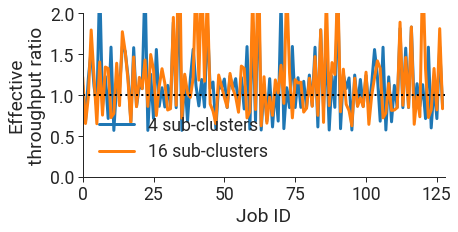

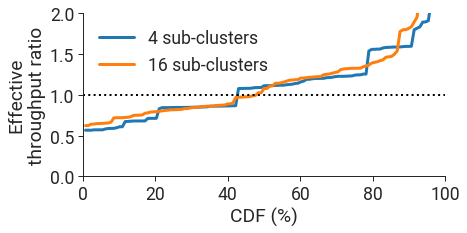

Random placement


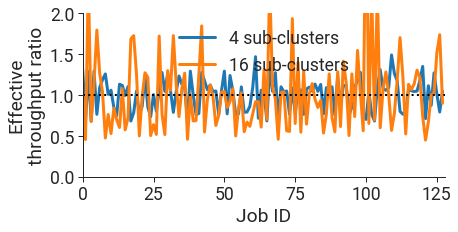

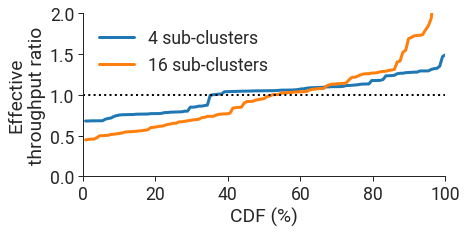

In [7]:
print("Round-robin placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        num_jobs=128, priority_reweighting_policy='fairness',
        random_throughputs=False,
        random_cluster_assignment=False))
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        num_jobs=128, priority_reweighting_policy='fairness',
        random_throughputs=False,
        random_cluster_assignment=False),
    cdf=True)
print("Random placement")
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        num_jobs=128, priority_reweighting_policy='fairness',
        random_throughputs=False,
        random_cluster_assignment=True))
plot_effective_throughput_ratios(
    get_effective_throughput_ratios(
        num_jobs=128, priority_reweighting_policy='fairness',
        random_throughputs=False,
        random_cluster_assignment=True),
    cdf=True)